# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [13]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist

import micmac as micmac

In [14]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

In [15]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


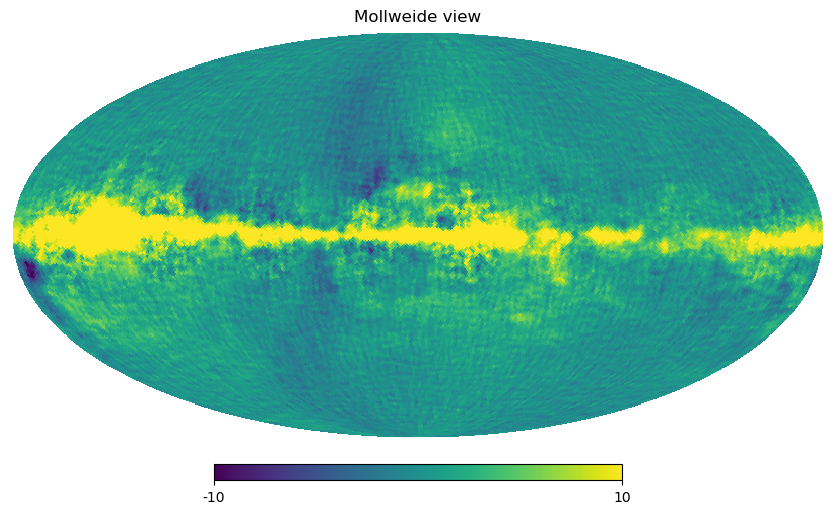

In [16]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npix

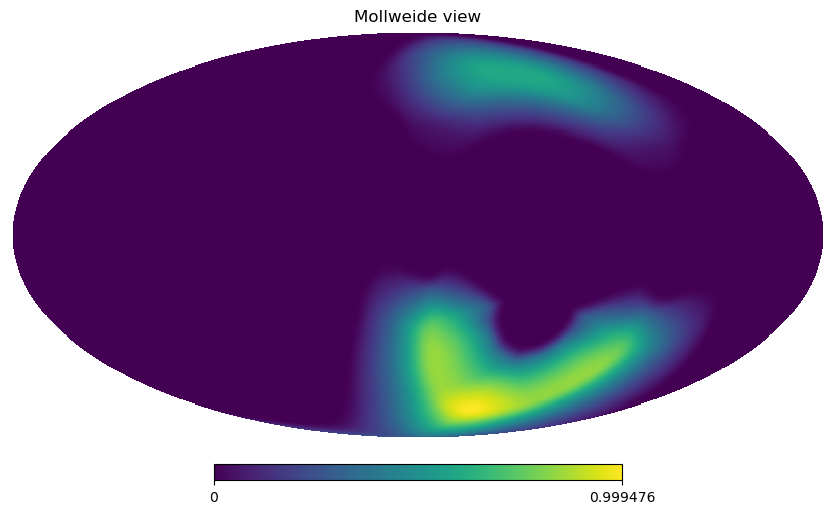

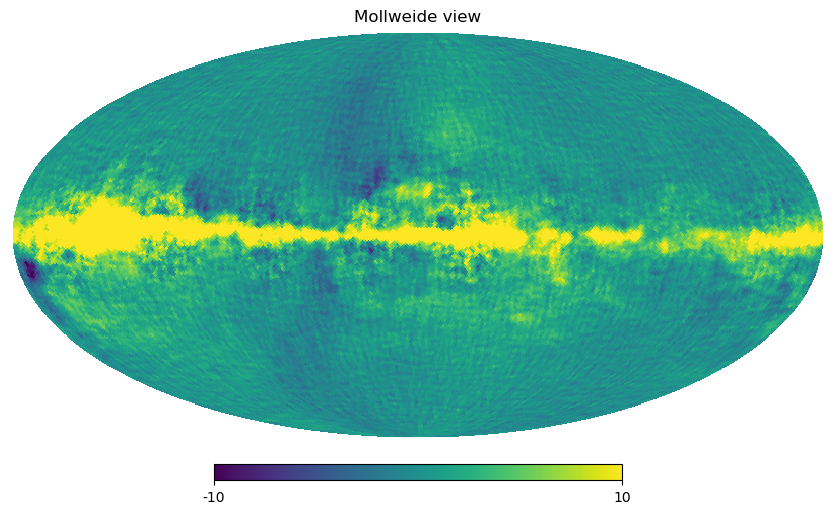

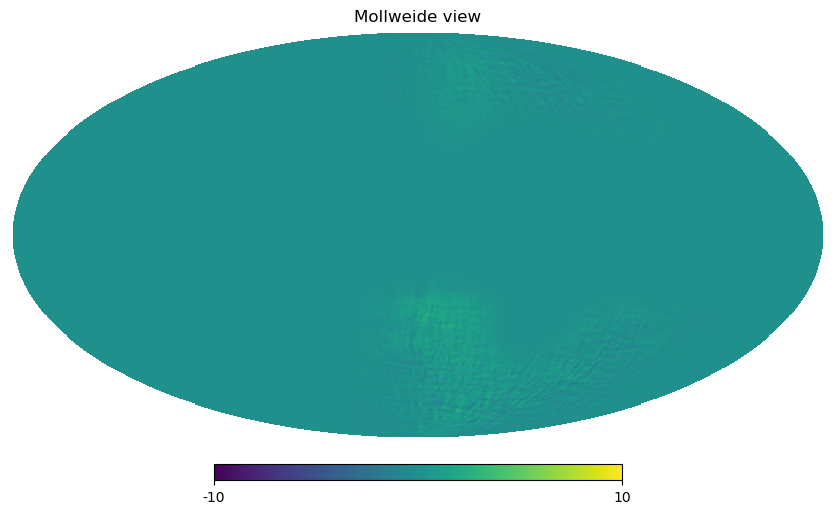

In [17]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npixhp.mollview(freq_maps[0,0]) # Freq, nstokes, npix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, npix

In [20]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v4/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'


In [21]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [22]:
reduction_noise = 1

In [23]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [24]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [25]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [26]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [27]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')
        
# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [28]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [29]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [30]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  None iterations !!
Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!


In [31]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [32]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [33]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


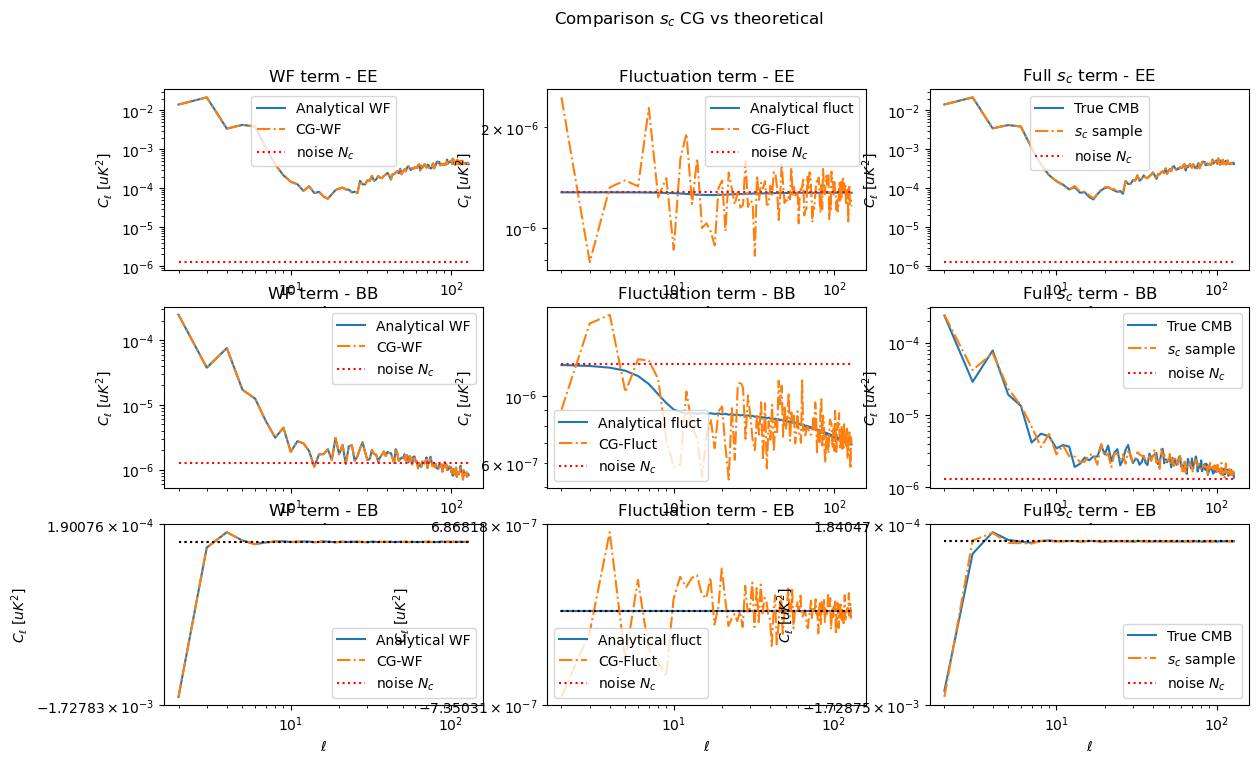

In [34]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [106]:
# number_steps_sampler = 5000
number_steps_sampler = 5000
# number_steps_sampler = 100
initial_step_size_r = 10**(-3)
# initial_step_size_r = 10**(-6)
initial_guess_r = 1e-2
initial_guess_r = 1e-4
# initial_guess_r = MICMAC_sampler_obj.r_true*0.99999

num_sample_AM = 1000
epsilon_cov = 10**(-20)
scale_param = 2.4**2

In [107]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)

In [151]:
s_c_sample_masked = np.copy(s_c_sample)
s_c_sample_masked[:,mask==0] = 0

In [153]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
# c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
# c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample_masked, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)

In [155]:
true_cmb = np.zeros((6,lmax+1))
true_cmb[indices_polar,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)
map_s_c = hp.synfast(true_cmb, nside, lmax=lmax, new=True)[1:]

In [156]:
c_ells_Wishart_modified = jnp.copy(c_ells_Wishart)
# for i in range(self.nstokes):
for i in range(c_ells_Wishart.shape[0]):
        c_ells_Wishart_modified = c_ells_Wishart_modified.at[i].set(c_ells_Wishart_modified[i] * (2*jnp.arange(MICMAC_sampler_obj.lmax+1) + 1))
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)[MICMAC_sampler_obj.lmin:]


In [157]:
%%time

all_r_sample = jnp.zeros(number_steps_sampler+1)
all_r_sample = all_r_sample.at[0].set(initial_guess_r)

# all_r_sample_slow = jnp.zeros(number_steps_sampler+1)
# all_r_sample_slow = all_r_sample_slow.at[0].set(initial_guess_r)

for i in range(0,number_steps_sampler+1):
    old_PRNGKey, PRNGKey = random.split(PRNGKey)
    if i < num_sample_AM:
        step_size_r = initial_step_size_r
    else:
        step_size_r = jnp.sqrt(scale_param*(jnp.var(all_r_sample[:i]) + epsilon_cov))
    if i%100 == 0:
        print(i, step_size_r)
    # all_r_sample[i+1] = micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey+3, old_sample=all_r_sample[i], 
    #                                     step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
    #                                     red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)
    # all_r_sample = all_r_sample.at[i+1].set(micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey, old_sample=all_r_sample[i], 
    #                                     step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
    #                                     red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
    all_r_sample = all_r_sample.at[i+1].set(single_lognormal_Metropolis_Hasting_step(random_PRNGKey=PRNGKey, old_sample=all_r_sample[i], 
                                        step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
                                        red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
    # all_r_sample_slow = all_r_sample_slow.at[i+1].set(micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey+3+i, old_sample=all_r_sample[i], 
    #                                     step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_slow_conditional_proba_C_from_r, 
    #                                     map_s_c=map_s_c, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))


0 0.001
100 0.001
200 0.001
300 0.001
400 0.001
500 0.001
600 0.001
700 0.001
800 0.001
900 0.001
1000 0.014913464719778113
1100 0.01428603949468964
1200 0.013726919671006045
1300 0.013304133057998255
1400 0.012868018647931977
1500 0.012450608246474095
1600 0.012079959053516123
1700 0.011743767681647045
1800 0.011427535437459536
1900 0.011137798097064675
2000 0.010868160165097866
2100 0.01062555123553529
2200 0.010403542901530663
2300 0.010188527970587185
2400 0.009976759907199931
2500 0.009790328284850965
2600 0.009613322866756237
2700 0.009445738694344044
2800 0.009280122158421613
2900 0.009132982019416643
3000 0.008983438340853236
3100 0.008848292505849807
3200 0.00871312829638717
3300 0.00858513456996475
3400 0.008460640193121037
3500 0.00834239348959608
3600 0.008234832629097483
3700 0.008132182293505165
3800 0.008027604268464833
3900 0.007930529601841771
4000 0.007841072641965804
4100 0.0077488785108253185
4200 0.007656803499440483
4300 0.007570936560543401
4400 0.007489751014174

In [158]:
log_space_r = np.logspace(-8,3, num=100)

if MICMAC_sampler_obj.r_true != 0:
        log_r_true = np.log10(MICMAC_sampler_obj.r_true)
        gap = .1
        log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [159]:
all_logproba_samples = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_sample, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_sample in all_r_sample])

In [160]:
# if MICMAC_sampler_obj.r_true != 0:
#         log_r_true = np.log10(MICMAC_sampler_obj.r_true)
#         gap = .7
#         log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
# else:
#         log_space_r = np.logspace(-20,-2, num=100)

# all_logproba_r_slow = np.array([MICMAC_sampler_obj.get_slow_conditional_proba_C_from_r(r_logspace, map_s_c=map_s_c, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [161]:
r_fit = all_r_sample.mean()
print('R_fit :', r_fit)
r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
print('R_max :', r_max)

R_fit : 0.03040697687264836
R_max : 0.012589254117941675


In [162]:
# r_fit_slow = all_r_sample_slow.mean()
# print('R_fit :', r_fit)
# r_max_slow = log_space_r[np.where(all_logproba_r_slow==all_logproba_r_slow.max())[0][0]]
# print('R_max :', r_max)

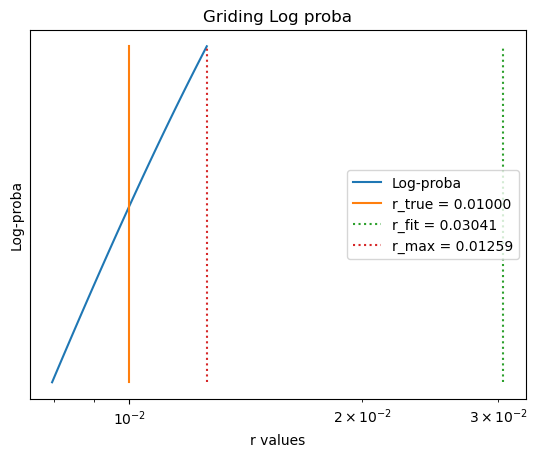

In [163]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_fit))
plt.plot([r_max, r_max], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_max = {:.5f}'.format(r_max))
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [164]:
# plt.plot(log_space_r, all_logproba_r_slow, label='Log-proba')
# plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
# plt.plot([r_fit_slow, r_fit_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_fit = {:.5f}'.format(r_fit_slow))
# plt.plot([r_max_slow, r_max_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_max = {:.5f}'.format(r_max_slow))
# # plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# # plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
# plt.xscale('log')
# plt.yscale('symlog')
# plt.xlabel('r values')
# plt.ylabel('Log-proba')
# plt.title('Griding Log proba slow')
# # plt.ylim(ymax=all_logproba_r.max())
# plt.legend()
# plt.show()

In [165]:
all_r_sample.shape

(5001,)

In [166]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + all_r_sample[i]*theoretical_red_cov_r1_tensor
    


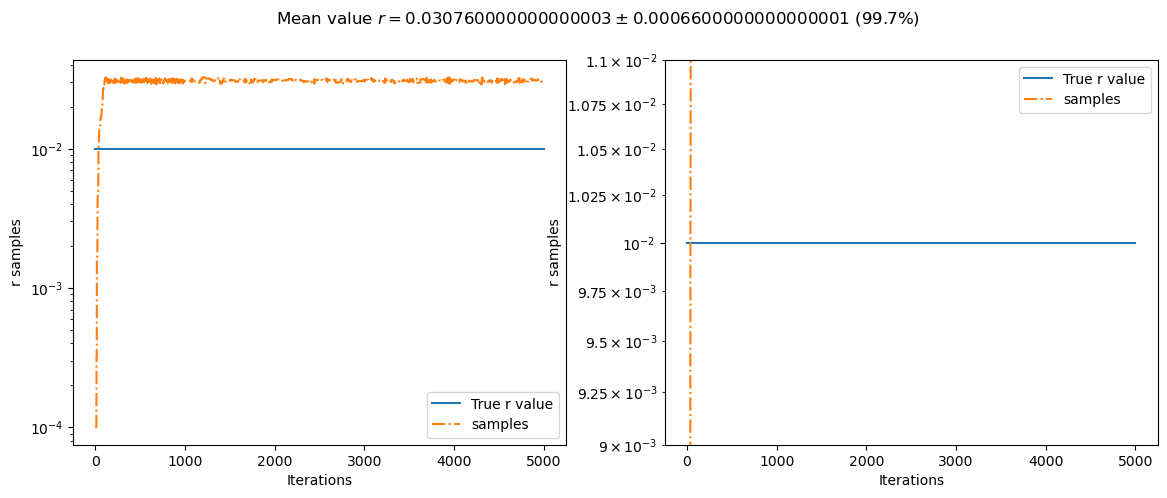

In [167]:
plt.figure(figsize=(14,5))

n_sigma = 3
transformed_samples = np.abs(all_r_sample - all_r_sample.mean())/(all_r_sample.std()) #< n_sigma
cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
mean_r = np.round(all_r_sample[cond].mean(), decimals=5)
std_r = np.round(all_r_sample[cond].std(), decimals=5)
plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")

plt.subplot(121)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.title('')
# plt.loglog()
plt.yscale('log')
plt.legend()

plt.subplot(122)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
# plt.loglog()
plt.yscale('log')
plt.legend()
plt.ylim(ymin=MICMAC_sampler_obj.r_true*.9, ymax=MICMAC_sampler_obj.r_true*1.1)
plt.show()

plt.show()

In [168]:
log_proba_r_true = MICMAC_sampler_obj.get_conditional_proba_C_from_r(MICMAC_sampler_obj.r_true, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)

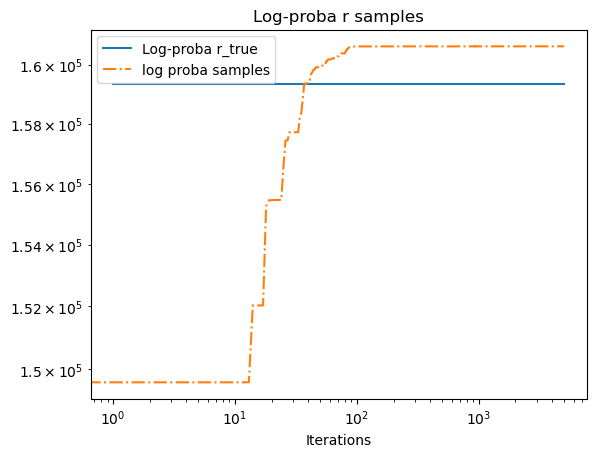

In [169]:
plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), all_logproba_samples[:], '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r samples')
plt.loglog()
plt.legend()
plt.show()

In [170]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), -(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r_true - Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.subplot(122)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('e^(- (Log-proba r_true - Log-proba r samples))')
plt.loglog()
plt.legend()
plt.show()

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_51416/2405200647.py:13: RuntimeWarning: overflow encountered in exp
  plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/matplotlib/ticker.py:2418: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


OverflowError: cannot convert float infinity to integer

<Figure size 1400x400 with 2 Axes>

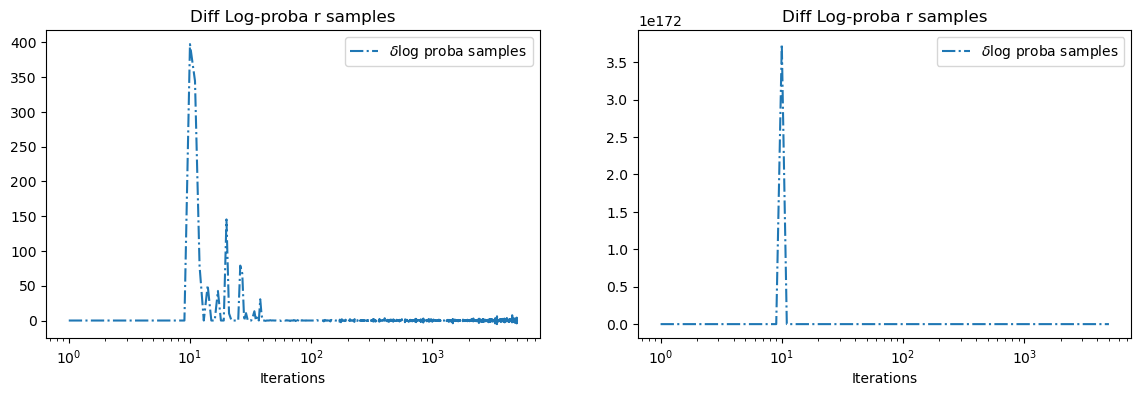

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler)+1, all_logproba_samples[1:]-all_logproba_samples[:-1], '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.show()